<a href="https://colab.research.google.com/github/jooj-uni/neural-signal-analysis-bci/blob/master/pseudo_online_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install mne
!pip install moabb
!pip install "scikit-learn<1.4"


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 41.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 48.2 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.3.2
    Uninstalling scikit-learn-1.3.2:
      Successfully uninstalled scikit-learn-1.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.4.1 which is incompatible.
tensorflow 2.19.0 requires numpy<2.2.0,>=1.26.0, but you have numpy 2.4.1 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 2.4.1 which is incompatible.
opencv-python 4.12.0.88 re

  Using cached scikit_learn-1.3.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
  Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached scikit_learn-1.3.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (10.8 MB)
Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.0 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.4.1
    Uninstalling numpy-2.4.1:
      Successfully uninstalled numpy-2.4.1
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.8.0
    Uninstalling scikit-learn-1.8.0:
      Successfully uninstalled scikit-learn-1.8.0
ERROR: Operation cancelled by user
^C


In [2]:
import warnings

import matplotlib.pyplot as plt
import mne
import seaborn as sns
from mne.decoding import CSP
from pyriemann.classification import MDM
from pyriemann.estimation import Covariances
from pyriemann.tangentspace import TangentSpace

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import FunctionTransformer


import moabb
from moabb.datasets import BNCI2014_001, Zhou2016, Stieger2021
from moabb.evaluations import WithinSessionEvaluation
from moabb.paradigms import LeftRightImagery

import numpy as np
import pandas as pd
import seaborn as sns



import os

In [3]:
# Caminho seguro no Colab
mne_path = "/content/mne_data"
os.environ["MNE_DATA"] = mne_path
os.environ["MNE_DATASETS_SAMPLE_PATH"] = mne_path
os.environ["MOABB_RESULTS"] = mne_path # Set MOABB results directory using os.environ
os.makedirs(mne_path, exist_ok=True)

# Forçar MNE a registrar o caminho internamente
mne.set_config("MNE_DATA", mne_path, set_env=True)
mne.set_config("MNE_DATASETS_SAMPLE_PATH", mne_path, set_env=True)

Attempting to create new mne-python configuration file:
/root/.mne/mne-python.json
Could not read the /root/.mne/mne-python.json json file during the writing. Assuming it is empty. Got: Expecting value: line 1 column 1 (char 0)


In [64]:
import numpy as np
import moabb
import mne

from sklearn.metrics import matthews_corrcoef
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression

from scipy.signal import butter, lfilter

import time
import matplotlib.pyplot as plt
import pandas as pd

REST_LABEL = 0
REJECT_LABEL = -1

class PseudoOnlineWindow():
    """
    Segments data in windows for pseudo-online analysis.


    Parameters:
        raw: mne.Raw object
            The continuous data.
        events: arra
            MNE event array.
        interval: list
            Dataset parameter defining imagery interval.
        task_ids: dict
            Defines the tasks and its numeric IDs. It can be used to select a subset of the dataset tasks.
        window_size: float
            The window size in seconds.
        window_step: int
            Distance in seconds between the start of two consecutive windows. It can be used to set superposition between windows, when value is lower than window_size.

    """
    def __init__(self, raw, events, interval, task_ids, window_size, window_step, chan_list=None):
        self.raw = raw
        self.events = events
        self.interval = interval
        self.sfreq = raw.info['sfreq']
        self.task_ids = task_ids

        self.window_size = int(window_size * self.sfreq)
        self.window_step = int(window_step * self.sfreq)
        self.chan_list = chan_list

        self.t_start = int(interval[0] * self.sfreq)
        self.t_end = int(interval[1] * self.sfreq)

        self.labels = self.generate_labels()

    def generate_labels(self):
        """
        Attributes aa label for each sample. The label vector is initialized with 0 and each data point is attributed to the task label, if it is in imagery period.

        Returns:
            labels: nd array
                Label vector containing labels for each data sample.
        """

        n_samples = self.raw.n_times
        labels = np.zeros(n_samples, dtype=int)

        valid_ids = list(self.task_ids.values())

        for ev in self.events:
            ev_idx, _, ev_id = ev

            if ev_id in valid_ids:
                # uses only imagery period for task attribution
                start = ev_idx + self.t_start
                stop = ev_idx + self.t_end

                # ensure array limits
                start = max(0, start)
                stop = min(n_samples, stop)

                labels[start:stop] = ev_id
        return labels


    def generate_windows(self):
        """
        Generates and labels windows.

        Returns:
            X: nd array shape=(n_windows, n_channels, n_times)
                The windows (data).
            y: nd array
                Window labels in the same order as X.
            times: nd array
                Array of tuples. Each tuple is the timestamps (start and end) of each window. Might be useful for plotting.
        """
        X, y, times = [], [], []

        data = self.raw.get_data()
        n_samples = data.shape[1]

        for start_idx in range (0, n_samples - self.window_size, self.window_step):
            end_idx = start_idx + self.window_size

            if self.chan_list == None:
                window_data = data[:, start_idx : end_idx]
                window_labels = self.labels[start_idx:end_idx]
            else:   #channel selection
                window_data = []
                for chan in self.chan_list:
                    if chan in self.raw.ch_names:
                        window_data.append(data[chan, start_idx : end_idx])
                    else:
                        raise ValueError(f"Channel {chan} is not in {self.raw.ch_names}")
                window_labels = self.labels[start_idx:end_idx]

            count = np.bincount(window_labels)
            major = np.argmax(count)

            prop_major = count[major] / len(window_labels)

            # class draw proportion
            n_classes = len(np.unique(window_labels))
            draw_prop = 1 / n_classes

            # in case of draw, the posterior label wins
            if prop_major != draw_prop:
                y.append(major)
            else:
                y.append(window_labels[-1])

            X.append(window_data)
            times.append(((start_idx / self.sfreq), (end_idx / self.sfreq)))

        return np.array(X), np.array(y), np.array(times)


class IdleBaseline(BaseEstimator, TransformerMixin):
    """
    Applies baseline correction. It uses a fixed baseline. This transformer has to be applied to windowed data.

    Parameters:
        rest_label: int
            Label representing idle state.

    Returns:
        X: nd array shape=(n_windows, n_channels, n_times)
            Baseline corrected windowed data.
    """

    def __init__(self, rest_label=REST_LABEL):
        self.rest_label = rest_label

    def fit(self, X, y=None):
        if y is None:
            raise ValueError("Missing labels array")

        idle_windows = (y == self.rest_label)

        if not np.any(idle_windows):
            raise ValueError("There are no rest windows")

        self.baseline_ = X[idle_windows].mean(axis=0)
        return self

    def transform(self, X):
        return np.subtract(X, self.baseline_)


class ArrayFilter(BaseEstimator, TransformerMixin):
    """
    If output is used directly on classifier, function transformer to reshape data needs to be used.
    """
    def __init__(self, sfreq, lfreq=1, hfreq=100):
        self.sfreq = sfreq
        self.lfreq = lfreq
        self.hfreq = hfreq

    def fit(self, X, y=None):
        b, a = butter(
        N=4,
        Wn=[self.lfreq, self.hfreq],
        btype='bandpass',
        fs=self.sfreq
        )

        self.a_ = a
        self.b_ = b

        return self

    def transform(self, X):
        X_filt = lfilter(self.b_, self.a_, X, axis=-1)

        return np.array(X_filt)

class PSD(BaseEstimator, TransformerMixin):
    """
    If output is used directly on classifier, function transformer to reshape data needs to be used.
    """
    def __init__(self, sfreq, fmin=0, fmax=None):
        self.sfreq = sfreq
        self.fmin = fmin
        self.fmax = fmax

    def fit (self, X, y=None):
        return self

    def transform(self, X):

        fmax = self.fmax if self.fmax is not None else self.sfreq / 2

        n_seg = int(len(X[0, 0, :])/2)
        if n_seg > 256:
            n_fft = n_seg
        else:
            n_fft = 256

        psds, _ = mne.time_frequency.psd_array_welch(X,
                                                     sfreq=self.sfreq,
                                                     fmin=self.fmin,
                                                     fmax=self.fmax,
                                                     n_per_seg=n_seg,
                                                     n_fft=n_fft,
                                                     average='mean')

        psds = np.array(psds)

        return psds

"""
deprecated

class IdleDetection():
    #Classifier for idle state detection.
    def __init__(self, model, threshold=0.6):
        self.threshold = threshold
        self.model = model

    def fit(self, X, y):
        y_idle = (y != REST_LABEL).astype(int)
        self.model.fit(X, y_idle)
        return self

    def is_idle(self, window):
        p_idle = self.model.predict_proba(window)[0, 0]

        if p_idle < self.threshold:
            return 0, p_idle
        else:
            return 1, p_idle
"""

class PseudoOnlineEvaluation():
    """
    Evaluates windowed data in pseudo-online manner (simulating real time asynchronous BCI). It can be done within-session, evaluating only one session data, or inter-session, evaluating performance across sessions, without
    breaking signal causality.

    Parameters:
        dataset: MOABB dataset
            Dataset to be used. It has to be a MOABB dataset object.
        pipelines: dict
            Sklearn pipelines dictionary, as used in MOABB.
        method: string
            Either 'within-session' or 'inter-session'.
                within-session: trains models on first k windows, testing on the remaining ones.
                inter-session: trains models on first k sessions, testing on the remaining ones; doesn't violate data causality.
        wsize: float
            Window size.
        wstep: int
            Distance between consecutive windows (start to start).
        subjects: list
            List of subjects to process.
        ratio: float
            Proportion of data to be used in training.
        threshold: float
            Confidence threshold for classification.

    """
    def __init__(self, dataset, class_pipelines, method, wsize, wstep, subjects, idle_pipelines=None, two_stage=True, ratio=0.7, idle_threshold=0.6, task_threshold=0.6, no_run=False):
        self.dataset = dataset
        self.class_pipelines = class_pipelines
        self.ratio = ratio
        self.method = method
        self.wsize = wsize
        self.wstep = wstep
        self.subjects = subjects
        self.idle_threshold = idle_threshold
        self.task_threshold = task_threshold
        self.no_run = no_run
        self.idle_pipelines = idle_pipelines
        self.two_stage = two_stage

        self.results_ = []
        self.model_results_ = []

        if self.two_stage is True and self.idle_pipelines is None:
            raise AttributeError("Evaluation is set to two stage but has no idle_pipeline")

    def raw_concat(self, raw_list):
        """
        Auxiliary function for raw data concat.
        """
        if len(raw_list) == 0:
            raise ValueError("Raw list is empty.")
        elif len(raw_list) == 1:    #aqui, o raw de uma sessao pode ser constituido de 1 ou mais runs, por isso essa verificação
            if type(raw_list[0]) != list:
                return raw_list[0]
            else:
                return mne.concatenate_raws(raw_list[0])
        else:
            return mne.concatenate_raws(raw_list)

    def window_process(self, subject, sess, X_test, y_test, times_test):
        # window processing loop
        for window in range(len(X_test)):
            window_start = times_test[window][0]
            window_end = times_test[window][1]

            pipe_window = np.array([X_test[window]])

            """
            t_start = time.perf_counter()

            if (self.feature_pipeline != None):
                feature_window = self.feature_pipeline.transform([X_test[window]])
            else:
                feature_window = np.array([X_test[window]])
                idle_window = np.reshape(feature_window, (feature_window.shape[0], -1))

            t_end = time.perf_counter()

            t_transform = t_end - t_start
            """

            t_start = time.perf_counter()

            if self.two_stage is True:
                for idle_name, idle_pipe in self.idle_pipelines.items():
                    idle_proba = idle_pipe.predict_proba(pipe_window)[0, 0]

                    is_idle = 0 if idle_proba < self.idle_threshold else 1

                    t_end = time.perf_counter()
                    t_idle_detect = t_end - t_start

                    task_proba = None
                    probs = None

                    if not is_idle:
                        for name, pipe in self.class_pipelines.items():
                            t_start = time.perf_counter()

                            probs = pipe.predict_proba(pipe_window)[0]

                            task_proba = np.max(probs)

                            if task_proba < self.task_threshold:
                                y_pred = REJECT_LABEL
                            else:
                                y_pred = (probs.argmax() + 1)    #to offset rest label

                            t_end = time.perf_counter()

                            t_task_predict = t_end - t_start

                            correct = (y_pred == y_test[window])

                            correct_proba = probs[(y_test[window] - 1)] if y_test[window] != REST_LABEL else idle_proba

                            res = {
                                "dataset": self.dataset,
                                "subject": subject,
                                "session": sess,
                                "method": self.method,
                                "idle_pipeline": idle_name,
                                "task_pipeline": name,
                                "window": window,
                                "window_start": window_start,
                                "window_end": window_end,
                                "is_idle": is_idle,
                                "t_idle_detect": t_idle_detect,
                                "t_task_predict": t_task_predict,
                                "t_predict": (t_idle_detect + t_task_predict),
                                "y_pred": y_pred,
                                "idle_proba": idle_proba,
                                "task_proba": task_proba,
                                "cor_proba": correct_proba,
                                "y_true": y_test[window],
                                "correct": correct
                            }

                            self.results_.append(res)
                    else:
                        y_pred = REST_LABEL
                        t_task_predict = 0
                        correct = (y_pred == y_test[window])


                        res = {
                            "dataset": self.dataset,
                            "subject": subject,
                            "session": sess,
                            "method": self.method,
                            "idle_pipeline": idle_name,
                            "task_pipeline": None,
                            "window": window,
                            "window_start": window_start,
                            "window_end": window_end,
                            "is_idle": is_idle,
                            "t_idle_detect": t_idle_detect,
                            "t_task_predict": t_task_predict,
                            "t_predict": (t_idle_detect + t_task_predict),
                            "y_pred": y_pred,
                            "idle_proba": idle_proba,
                            "task_proba": task_proba,
                            "cor_proba": None,
                            "y_true": y_test[window],
                            "correct": correct
                        }

                        self.results_.append(res)
            else:
                for name, pipe in self.class_pipelines.items():
                    t_start = time.perf_counter()

                    probs = pipe.predict_proba(pipe_window)[0]

                    task_proba = np.max(probs)
                    idle_proba = probs[0]

                    if task_proba < self.task_threshold:
                        y_pred = REJECT_LABEL
                    else:
                        y_pred = probs.argmax()

                    t_end = time.perf_counter()

                    t_task_predict = t_end - t_start

                    correct = (y_pred == y_test[window])

                    res = {
                        "dataset": self.dataset,
                        "subject": subject,
                        "session": sess,
                        "method": self.method,
                        "idle_pipeline": name,
                        "task_pipeline": name,
                        "window": window,
                        "window_start": window_start,
                        "window_end": window_end,
                        "is_idle": int(y_pred == REST_LABEL),
                        "t_idle_detect": t_task_predict if y_pred == REST_LABEL else None,
                        "t_task_predict": t_task_predict,
                        "t_predict": t_task_predict,
                        "y_pred": y_pred,
                        "idle_proba": idle_proba,
                        "task_proba": task_proba,
                        "y_true": y_test[window],
                        "correct": correct
                    }

                    self.results_.append(res)

    def idle_train(self, X_train, y_train):
        y_idle = (y_train == REST_LABEL).astype(int)

        p1 = len(y_idle[y_idle == 1])
        p2 = len(y_idle[y_idle == 0])

        print(f"idle qtd: {p1}, task qtd: {p2}")

        for name, pipe in self.idle_pipelines.items():
            print(f"fitting idle pipeline {name}...")

            t_start = time.perf_counter()
            pipe.fit(X_train, y_idle)
            t_end = time.perf_counter()

            t_idle_train = t_end - t_start

            res = {
                "idle_pipeline": name,
                "method": self.method,
                "t_train": t_idle_train

            }

            self.model_results_.append(res)

            print("done fitting idle detector")
        return self

    def task_train(self, X_train, y_train):
        if self.two_stage is True:
            # mask for task windows
            mask = y_train != REST_LABEL
            X_task = X_train[mask]
            y_task = y_train[mask]
        else:
            X_task = X_train
            y_task = y_train

        # task classifier training
        for name, pipe in self.class_pipelines.items():
            print(f"Fitting task pipeline {name}...")
            t_start = time.perf_counter()
            pipe.fit(X_task, y_task)
            t_end = time.perf_counter()

            t_train = t_end - t_start
            print("Done fitting!")

            res = {
                "task_pipeline": name,
                "method": self.method,
                "t_train": t_train

            }

            self.model_results_.append(res)

        return self


    def evaluate(self):
        """
        Main function for processing data.
        """

        for subject in self.subjects:
            if subject not in self.dataset.subject_list:
                raise ValueError(f"Invalid subject index: {subject}")
            else:
                print(f"Processing subject {subject}...")

                raws_dict = {}
                raws_test = {}
                pre = self.dataset.get_data(subjects=[subject])

                session_keys = []   # stores session ids (not always int)

                if self.method == 'within-session':

                    # raw extraction from moabb dataset
                    for _, runs in pre.items():
                        for sess, dicts in runs.items():
                            session_keys.append(sess)
                            raws_dict[sess] = []
                            for _, data in dicts.items():
                                raws_dict[sess].append(data)

                    for sess in session_keys:
                        print(f"Processing session {sess} subject {subject}...")
                        raw = self.raw_concat(raws_dict[sess])
                        events, event_ids = mne.events_from_annotations(raw)

                        self.events = events

                        wgen = PseudoOnlineWindow(raw=raw,
                                                events=events,
                                                interval=self.dataset.interval,
                                                task_ids=event_ids,
                                                window_size=self.wsize,
                                                window_step=self.wstep
                                                )

                        X, y, times = wgen.generate_windows()

                        idx_split = int(len(X) * self.ratio)

                        times_test = times[idx_split:]

                        X_train, y_train = X[:idx_split], y[:idx_split]
                        X_test, y_test = X[idx_split:], y[idx_split:]

                        if (self.no_run):
                            return X_train, y_train, X_test, y_test

                        if self.two_stage is True:
                            self.idle_train(X_train, y_train)

                        self.task_train(X_train, y_train)

                        self.task_threshold = ((1/len(np.unique(y_train[y_train != REST_LABEL]))) + 0.05)
                        print(f"task threshold is {self.task_threshold}")

                        self.window_process(subject, sess, X_test, y_test, times_test)


                elif self.method == 'inter-session':
                    if self.dataset.n_sessions > 1:
                        session_split = int(self.ratio * self.dataset.n_sessions)
                        raws_list = []
                        raws_train = []

                        print(f"Splitting index is {session_split}, dataset has {self.dataset.n_sessions} sessions per subject.")

                        for _, runs in pre.items():
                            for sess, dicts in runs.items():
                                session_keys.append(sess)
                                raws_test[sess] = []
                                raws_dict[sess] = []
                                for _, data in dicts.items():
                                    raws_dict[sess].append(data)

                        #essa verificação é porque eu acahva que o int() arredondava pra cima o valor... de todo jeito, nao faz mal deixar isso aqui
                        if session_split == self.dataset.n_sessions:
                            train_sessions = session_keys[:(session_split - 1)]
                            test_sessions = session_keys[(session_split - 1):]
                            for sess, data in raws_dict.items():
                                if (session_keys.index(sess) + 1) < session_split:
                                    raws_list.append(data)
                                else:
                                    raws_test[sess].append(data)
                        else:
                            train_sessions = session_keys[:session_split]
                            test_sessions = session_keys[session_split:]
                            for sess, data in raws_dict.items():
                                if (session_keys.index(sess) + 1) <= session_split:
                                    raws_list.append(data)
                                else:
                                    raws_test[sess].append(data)


                        raws_train = self.raw_concat(raws_list)

                        events, event_ids = mne.events_from_annotations(raws_train)

                        wgen_train = PseudoOnlineWindow(raw=raws_train,
                                                            events=events,
                                                            interval=self.dataset.interval,
                                                            task_ids=event_ids,
                                                            window_size=self.wsize,
                                                            window_step=self.wstep
                                                            )

                        X_train, y_train, times_train = wgen_train.generate_windows()

                        if (self.no_run):
                            return X_train, y_train, X_test, y_test

                        if self.two_stage is True:
                            self.idle_train(X_train, y_train)

                        self.task_train(X_train, y_train)

                        for sess in test_sessions:
                            print(f"Testing in session {sess}...")

                            raws = self.raw_concat(raws_test[sess])

                            events, event_ids = mne.events_from_annotations(raws)

                            wgen_test = PseudoOnlineWindow(raw=raws,
                                                                events=events,
                                                                interval=self.dataset.interval,
                                                                task_ids=event_ids,
                                                                window_size=self.wsize,
                                                                window_step=self.wstep
                                                                )

                            X_test, y_test, times_test = wgen_test.generate_windows()

                            self.window_process(subject, sess, X_test, y_test, times_test)
                    else:
                        raise ValueError("There are not enough sessions for evaluation.")

            if len(self.results_):
                results_ = pd.DataFrame(self.results_)
                results_.to_csv(f"results-S{subject}.csv", index=False)
                self.results_ = []
            if len(self.model_results_):
                model_results_ = pd.DataFrame(self.model_results_)
                model_results_.to_csv(f"model-results-S{subject}.csv", index=False)
                self.model_results_ = []




                                   # mcc_acc_sess = matthews_corrcoef(y_test[:window+1], predictions_sess[:window+1])    #score acumulado dentro da sessão
                                   # mcc_acc = matthews_corrcoef(y_all, predictions)   #score acumulado entre sessões

In [74]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

dataset = BNCI2014_001()

pipelines = {}
idle_pipeline = {}

idle_pipeline ["csp+lr"] = make_pipeline(CSP(n_components=4), LogisticRegression())
idle_pipeline ["tgsp+lr"] = make_pipeline(Covariances(estimator='oas'), TangentSpace(metric='logeuclid'), LogisticRegression())

pipelines["csp+lda"] = make_pipeline(CSP(n_components=4), LDA())
pipelines["csp+lr"] = make_pipeline(CSP(n_components=4), LogisticRegression())
pipelines["tgsp+lr"] = make_pipeline(Covariances(estimator='oas'), TangentSpace(metric='logeuclid'),LogisticRegression())

eval = PseudoOnlineEvaluation(dataset=dataset, two_stage=True, class_pipelines=pipelines, idle_pipelines=idle_pipeline, method='within-session', wsize=2.0, wstep=0.5, ratio=0.7, idle_threshold=0.55, subjects=[1, 2], no_run=True)
x_train, y_train, x_test, y_test = eval.evaluate()

Processing subject 1...
Processing session 0train subject 1...
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']


In [75]:
print(eval.events)

[[   750      0      4]
 [  2753      0      1]
 [  4671      0      3]
 [  6623      0      2]
 [  8631      0      2]
 [ 10742      0      3]
 [ 12659      0      1]
 [ 14709      0      4]
 [ 16640      0      3]
 [ 18638      0      1]
 [ 20544      0      2]
 [ 22439      0      2]
 [ 24411      0      2]
 [ 26355      0      4]
 [ 28322      0      3]
 [ 30442      0      3]
 [ 32450      0      2]
 [ 34516      0      2]
 [ 36552      0      1]
 [ 38618      0      2]
 [ 40688      0      3]
 [ 42768      0      4]
 [ 44680      0      4]
 [ 46711      0      1]
 [ 48664      0      2]
 [ 50625      0      4]
 [ 52729      0      4]
 [ 54733      0      3]
 [ 56708      0      4]
 [ 58734      0      4]
 [ 60805      0      3]
 [ 62912      0      2]
 [ 65004      0      3]
 [ 67095      0      1]
 [ 69138      0      1]
 [ 71202      0      1]
 [ 73222      0      4]
 [ 75194      0      1]
 [ 77157      0      2]
 [ 79082      0      4]
 [ 81163      0      3]
 [ 83141      0 

<Axes: >

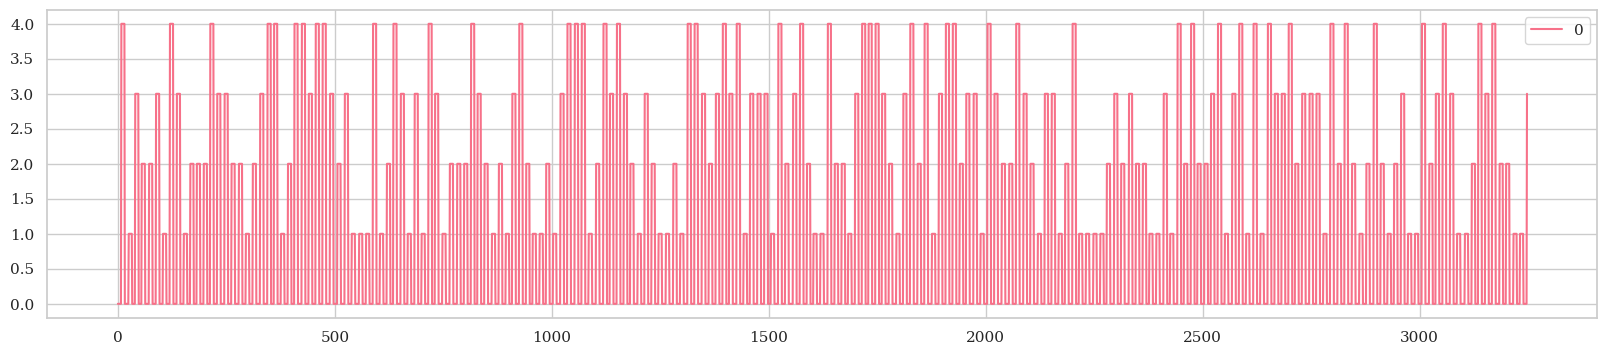

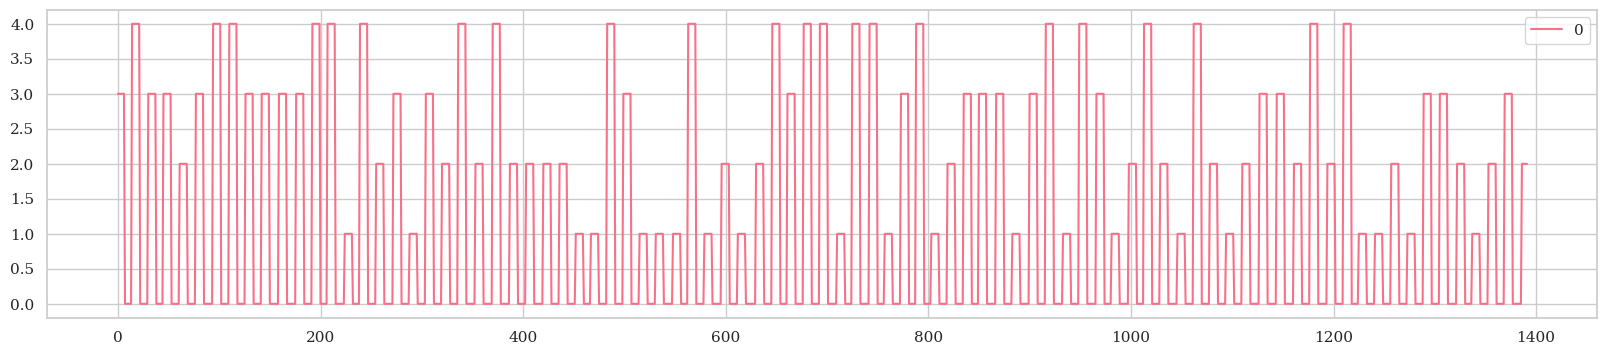

In [77]:
pd_train = pd.DataFrame(y_train)
pd_test = pd.DataFrame(y_test)

pd_train.plot(figsize=(20, 4))
pd_test.plot(figsize=(20, 4))

In [84]:
def count_alternancia_inv(labels):
  error_count = 0
  error_idxs = []

  for n in range(len(labels) - 1):
    if labels[n] != 0:
      if (labels[n+1] != 0) and (labels[n+1] != labels[n]):
        error_idxs.append(n)
        error_count += 1

  return error_count, error_idxs

In [81]:
def count_alternancia_rest(labels):
  count = 0
  idxs = []

  for n in range(len(labels) - 1):
    if labels[n] == 0:
      if labels[n+1] != 0:
        count += 1
        idxs.append(n)

  return count, idxs

In [86]:
errcount, erridxs = count_alternancia_inv(y_train)
count, idxs = count_alternancia_rest(y_train)

print(f"qtd de mudanças inválidas: {errcount}")

dists = np.diff(idxs)
mean = np.mean(dists)
std = np.std(dists)

print(f"distancia em amostras de entre rest e task {mean} +- {std}")

qtd de mudanças inválidas: 0
distancia em amostras de entre rest e task 16.114427860696516 +- 0.7066428204133203
